In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import gc
from tqdm import tqdm
import time
from datetime import datetime
import datetime as dt
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,roc_auc_score,roc_curve
import random
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score,f1_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, LSTM, Dropout,GRU,LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf

In [2]:
change_ratio = 1.5

In [3]:
TRAIN_OR_INFERENCE = 'INFERENCE'

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
tqdm.pandas()

In [5]:
def seed_everything(seed=51):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [6]:
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [7]:
seed_everything(seed=51)

In [8]:
def timer_decorator(function_to_call):
    def wrapper(*args,**kwargs):
        time_before = datetime.now()
        value_to_return =  function_to_call(*args,**kwargs)
        time_after = datetime.now()
        print(f"data elapsed = {time_after - time_before}")
        return value_to_return
    return wrapper

In [9]:
@timer_decorator
def read_data(path):
    df = pd.read_csv(path)
    print("========")
    print(f"Shape of data = {df.shape}")
    print("========")
    print("Column types are:")
    print(df.dtypes)
    print("========")
    print("Take a glance at data")
    print(pd.concat([df.head(),df.tail()],axis=0))
    print("========")
    return df

In [10]:
data = read_data('data_evaluate.csv')

Shape of data = (20324, 4)
Column types are:
btc_usdt         float64
eth_usdt         float64
eth_btc          float64
date_inserted     object
dtype: object
Take a glance at data
       btc_usdt  eth_usdt   eth_btc                  date_inserted
0      41547.36   3027.75  0.072876         2022-02-05 11:15:00+00
1      41506.98   3016.68  0.072681         2022-02-05 11:30:00+00
2      41454.42   3013.82  0.072698         2022-02-05 11:45:00+00
3      41507.00   3017.88  0.072706         2022-02-05 12:00:00+00
4      41564.07   3025.37  0.072788         2022-02-05 12:15:00+00
20319  19853.83   1576.59  0.079416  2022-09-05 03:00:03.025531+00
20320  19826.88   1571.68  0.079266  2022-09-05 03:15:02.425636+00
20321  19870.36   1575.83  0.079307   2022-09-05 03:30:04.17334+00
20322  19890.91   1576.87  0.079273   2022-09-05 03:45:04.11144+00
20323  19889.51   1576.16  0.079239  2022-09-05 04:00:02.486639+00
data elapsed = 0:00:00.035362


In [11]:
data = data[['date_inserted','btc_usdt']]
data.columns = ['time','open']

In [12]:
def copy_data(df):
    return df.copy()

In [13]:
@timer_decorator
def create_date_columns(df):
    df['time'] = pd.to_datetime(df['time'])
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df['day'] = df['time'].dt.day
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    return df

In [14]:
#data = create_date_columns(data)

In [15]:
@timer_decorator
def filter_data(df,drop_years, hour_to_keep, minute_to_keep):
    filter_ = (~df['year'].isin(drop_years)) & (df['hour'] % hour_to_keep == 0) & (df['minute'] == 0)
    return df[filter_]

In [16]:
#data = filter_data(data,[2012],4,0)

# Set Parameters

In [17]:
time_step = 120
next_period = 1
n_features = 1

In [18]:
@timer_decorator
def create_train_data(df,time_step,next_period):
    arr = np.array(df['open'])
    input_data = []
    target_data = []
    for i in tqdm(range(len(arr) - time_step)):
        input_data.append(arr[i:i+time_step])
        target_data.append(arr[i+time_step])
    input_data = np.asarray(input_data)
    target_data = np.asarray(target_data)
    mydata = pd.DataFrame(input_data,columns = ['T{}'.format(i) for i in range(1,time_step + 1,1)])
    mydata['target'] = target_data
    
    print(f"Training data size =  {mydata.shape}")
    
    return mydata

In [19]:
#data = create_train_data(data,time_step,next_period)

In [20]:
def label_maker(x):
    if x <= -1.5:
        return 0
    elif (-1.5 < x) & (x <= 1.5):
        return 1
    elif 1.5 < x :
        return 2
    else:
        pass

In [21]:
@timer_decorator
def create_label(df):
    df['scaled_target'] = (df.iloc[:,-1] - df.iloc[:,-2]) / df.iloc[:,-2]
    df['percentile_target'] = df['scaled_target']*100
    df['categorical_target_change'] = (df['percentile_target'].abs() > change_ratio) *1
    return df

In [22]:
#data = create_label(data)

In [23]:
data.tail()

,time,open
20319,2022-09-05 03:00:03.025531+00,19853.83
20320,2022-09-05 03:15:02.425636+00,19826.88
20321,2022-09-05 03:30:04.17334+00,19870.36
20322,2022-09-05 03:45:04.11144+00,19890.91
20323,2022-09-05 04:00:02.486639+00,19889.51


In [24]:
@timer_decorator
def create_columnwise_features(df,time_step):
    df['columnwise_min'] = df.iloc[:,:time_step].min(axis=1)
    df['columnwise_max'] = df.iloc[:,:time_step].max(axis=1)
    df['columnwise_median'] = df.iloc[:,:time_step].median(axis=1)
    return df

In [25]:
#data = create_columnwise_features(data,time_step)

In [26]:
def scale_btw_neg1_and_pos1(df,time_step):
    df[[f'T{x}' for x in range (1,time_step+1,1) ]] = \
    np.array([ np.interp( x, ( np.array(x).min(),np.array(x).max() ), (-1,1) )\
              for x in df[[f'T{x}' for x in range (1,time_step+1,1) ]].values.tolist() ])
    return df

In [27]:
def scale_btw_0_and_1(df,time_step):
    for i in range(1,time_step+1,1):
        df['T{}'.format(i)] = (df['T{}'.format(i)] - df['columnwise_min']) / (df['columnwise_max'] - df['columnwise_min'])
    return df

In [28]:
#data = scale_btw_0_and_1(data,time_step)

In [29]:
data.tail()

,time,open
20319,2022-09-05 03:00:03.025531+00,19853.83
20320,2022-09-05 03:15:02.425636+00,19826.88
20321,2022-09-05 03:30:04.17334+00,19870.36
20322,2022-09-05 03:45:04.11144+00,19890.91
20323,2022-09-05 04:00:02.486639+00,19889.51


In [30]:
def create_input_via_shifting(df, time_step):
    print(df.shape)
    for i in range(1,time_step+1,1):
        df['T{}'.format(time_step + 1 - i)] = df['categorical_target_change'].shift(i)
    
    df = df[time_step:].reset_index(drop=True)
    print(df.shape)
    return df

In [31]:
#data = create_input_via_shifting(data, time_step)

In [32]:
data.tail()

,time,open
20319,2022-09-05 03:00:03.025531+00,19853.83
20320,2022-09-05 03:15:02.425636+00,19826.88
20321,2022-09-05 03:30:04.17334+00,19870.36
20322,2022-09-05 03:45:04.11144+00,19890.91
20323,2022-09-05 04:00:02.486639+00,19889.51


In [33]:
#mydata['categorical_target'].value_counts(normalize=True)

In [34]:
data.head()

,time,open
0,2022-02-05 11:15:00+00,41547.36
1,2022-02-05 11:30:00+00,41506.98
2,2022-02-05 11:45:00+00,41454.42
3,2022-02-05 12:00:00+00,41507.00
4,2022-02-05 12:15:00+00,41564.07


In [35]:
data = (data.pipe(copy_data)
     .pipe(create_date_columns)
     .pipe(filter_data,drop_years = [2012],hour_to_keep = 4,minute_to_keep = 0)
     .pipe(create_train_data,time_step,next_period)
     .pipe(create_label)
     .pipe(create_input_via_shifting,time_step)
)

data elapsed = 0:00:00.018565
data elapsed = 0:00:00.003900


100%|██████████████████████████████████| 1151/1151 [00:00<00:00, 1139670.42it/s]

Training data size =  (1151, 121)
data elapsed = 0:00:00.005772
data elapsed = 0:00:00.002139
(1151, 124)
(1031, 124)


In [46]:
data[(data['categorical_target_change'] == 1) & (data['percentile_target'] < -change_ratio )]['percentile_target'].max()

-1.5043444430034936

# Create Train, Test, Valid

In [47]:
data['categorical_target_change'].value_counts(normalize=True)

0    0.793404
1    0.206596
Name: categorical_target_change, dtype: float64

In [48]:
def create_train_valid_test(df,time_step,train_ratio=0.0,valid_ratio=0.0):
    train_border = train_ratio
    valid_border = train_border + valid_ratio
    
    X_train = df[['T{}'.format(t) for t in range(1,time_step +1,1) ]][:int(len(df)*train_border)].values
    X_val = df[['T{}'.format(t) for t in range(1,time_step + 1,1) ]][int(len(df)*train_border):int(len(df)*valid_border)].values
    X_test = df[['T{}'.format(t) for t in range(1,time_step + 1,1) ]][int(len(df)*valid_border):].values
    
    y_train = df['categorical_target_change'][:int(len(df)*train_border)]
    y_val = df['categorical_target_change'][int(len(df)*train_border):int(len(df)*valid_border)]
    y_test = df['categorical_target_change'][int(len(df)*valid_border):]
    
    print(f"Train size = {len(X_train)}; Valid size = {len(X_val)}; Test size = {len(X_test)}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test
    

In [49]:
X_train, X_val , X_test, y_train, y_val, y_test = create_train_valid_test(data, time_step)

Train size = 0; Valid size = 0; Test size = 1031


# Create weights of classes inproportional to percentages

In [50]:
def create_weights(series):
    print("Class Distributions are ")
    print(series.value_counts(normalize=True))
    weight_dict= {x[0]: 1/x[1]  for x in series.value_counts(normalize=True).to_dict().items()}
    return weight_dict

In [51]:
weight_dict = create_weights(y_train)

Class Distributions are 
Series([], Name: categorical_target_change, dtype: float64)


# Oversampling data

In [52]:
from imblearn.over_sampling import SMOTE
def oversample_train(X,y):
    X,y = shuffle(X,y,random_state=60)
    smote = SMOTE(random_state=51)
    X,y = smote.fit_resample(X,y)
    print(X.shape,y.shape)
    return X,y

In [53]:
#X_train, y_train = oversample_train(X_train, y_train)

# Dummifacation of Target

In [54]:
def dummify_y_columns(training_y,valid_y,test_y):
    training_y = pd.get_dummies(training_y)
    valid_y = pd.get_dummies(valid_y)
    test_y = pd.get_dummies(test_y)
    print(f"Shapes after dummification in train, valid, test order = [{training_y.shape,valid_y.shape, test_y.shape}]")
    return training_y, valid_y, test_y

In [55]:
# y_train, y_val, y_test = dummify_y_columns(y_train, y_val, y_test)

# Resape Input for LSTM's

In [56]:
def reshape_input(training_X, valid_X, test_X, n_features):
    training_X = training_X.reshape((training_X.shape[0], training_X.shape[1], n_features))
    valid_X = valid_X.reshape((valid_X.shape[0], valid_X.shape[1], n_features))
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
    print(f"Shapes after reshaping are in order [{training_X.shape},{valid_X.shape}, {test_X.shape}]")
    return training_X, valid_X, test_X

In [57]:
X_train, X_val, X_test = reshape_input(X_train, X_val, X_test, n_features)

Shapes after reshaping are in order [(0, 120, 1),(0, 120, 1), (1031, 120, 1)]


In [58]:
from tensorflow.keras.models import load_model

In [59]:
# Load the model
model = load_model('model.h5')

2022-09-09 18:32:48.025328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 18:32:48.057753: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 18:32:48.057917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-09 18:32:48.059002: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Test

In [60]:
y_test_predicted = model.predict(X_test)

2022-09-09 18:32:50.142796: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


In [61]:
y_test_predicted

array([[0.3240849 ],
       [0.27318838],
       [0.2340537 ],
       ...,
       [0.07946251],
       [0.07728413],
       [0.07527353]], dtype=float32)

In [62]:
def plot_prediction_and_auc(predictions,true_values):
    plt.hist(predictions,bins=50, label = "Class 0")
    plt.legend()
    plt.show()
    
    print("AUC = {}".format(roc_auc_score(true_values,predictions)))
    
    fpr, tpr, _ = roc_curve(true_values,  predictions)
    auc = roc_auc_score(true_values, predictions)
    plt.plot(fpr,tpr,label="train, auc="+str(auc))
    plt.plot([0,1],[0,1])
    plt.legend(loc=4)
    plt.show()

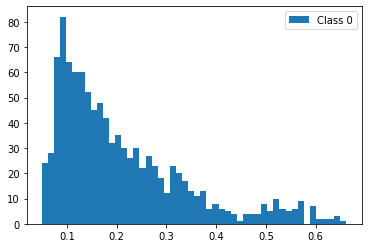

AUC = 0.6345317217075886


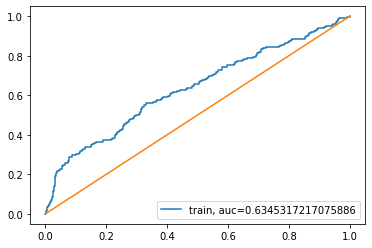

In [63]:
plot_prediction_and_auc(y_test_predicted[:,0],y_test)

In [64]:
def plot_precision_recall_f1(preds,truth):
    f1_list = []
    precision_list = []
    recall_list = []
    for i in np.arange(0.01,1.0,0.01):
        preds_converted = (preds >= i)*1
        
        f1_list.append( f1_score(truth,preds_converted) )
        precision_list.append( precision_score(truth,preds_converted,zero_division=0) )
        recall_list.append( recall_score(truth,preds_converted) )
    
    stats_data = pd.concat( [pd.Series(f1_list,name='f1'),pd.Series(precision_list,name='precision'),pd.Series(recall_list,name='recall')] , axis=1 )
    stats_data.index = np.arange(0.01,1.0,0.01)
    
    plt.plot(stats_data['f1'],label='f1')
    plt.plot(stats_data['precision'],label='precision')
    plt.plot(stats_data['recall'],label='recall')
    plt.xlabel('threshold')
    plt.ylabel('score')
    plt.legend()
    plt.show()

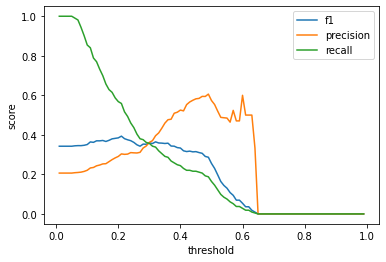

In [65]:
plot_precision_recall_f1(y_test_predicted,y_test)

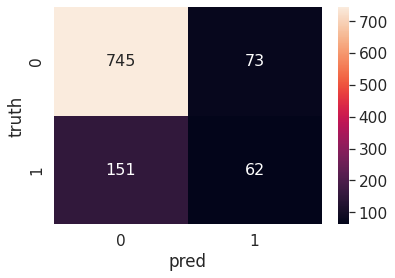

In [66]:
y_test_predicted_class = (y_test_predicted > 0.35) * 1

val_test = confusion_matrix(y_test,y_test_predicted_class)

df_cm = pd.DataFrame(val_test, range(2), range(2))
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g') # font size
plt.xlabel('pred')
plt.ylabel('truth')
plt.show()

In [67]:
data.shape[0] == X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

True